# Imports

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [2]:
from IPython.display import Image

## Initialize test data

In [3]:
# generate data exactly as in the example
rng = np.random.RandomState(0)
X = rng.uniform(0, 5, 20)[:, np.newaxis]
y = 0.5 * np.sin(3 * X[:, 0]) + rng.normal(0, 0.5, X.shape[0])

In [4]:
X_ = np.linspace(0, 5, 100)

In [5]:
kernel1 = 1.0 * RBF(length_scale=100.0, length_scale_bounds=(1e-2, 1e3)) \
    + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))
kernel2 = 1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)) \
    + WhiteKernel(noise_level=1e-5, noise_level_bounds=(1e-10, 1e+1))

## Some support functions

In [6]:
def print_GPs(GPs, name):
    plt.plot(X_, 0.5*np.sin(3*X_), label='ground truth')
    for i, gp in enumerate(GPs):
        print('gp - '+name+' (',i+1,'): ', gp, '\nkernel:', gp.kernel_)
        print('theta:', gp.kernel_.theta, np.exp(gp.kernel_.theta))
        print('likelihood:', gp.log_marginal_likelihood_value_)


    for i, gp in enumerate(GPs):
        y_mean, y_cov = gp.predict(X_[:, np.newaxis], return_cov=True)
        #plt.plot(X_, y_mean, 'k', lw=3, zorder=9, label='sklearn kernel: '+str(i+1))
        plt.plot(X_, y_mean, label='sklearn kernel: '+str(i+1))

    plt.legend()
    plt.tight_layout()

In [19]:
def make_plots(GPs):
    fig, ax = plt.subplots(2,1, figsize=(8.3,11.7))
    plt.subplots_adjust(hspace=.3)
    plt.rcParams.update({'font.size':12})
    #plt.title('Log Marginal Likelihood Surfaces with Prediction')
    for i, gp in enumerate(GPs):
        ax = plt.subplot(2,1,i+1)
        #ax = plt.subplot(1,1,1)
        if i==0: plt.title('Log Marginal Likelihood Surface for Low Noise Model')
        if i==1: plt.title('Log Marginal Likelihood Surface for High Noise Model')
        
        plt.scatter(np.exp(gp.kernel_.theta[1]), np.exp(gp.kernel_.theta[2]), c='red', marker='x')
        plt.ylabel('Noise Level')
        plt.xlabel('RBF Kernel Length Scale')
        
        a, b = gp.kernel_.bounds[1:]
        theta0 = np.linspace(a[0], a[1], 49)
        theta1 = np.linspace(b[0], b[1], 50)
        Theta0, Theta1 = np.meshgrid(theta0, theta1)
        LML = np.empty(Theta0.shape)
        for i in range(Theta0.shape[0]):
            for j in range(Theta0.shape[1]):
                LML[i,j] = gp.log_marginal_likelihood(np.array([gp.kernel_.theta[0], Theta0[i, j], Theta1[i, j]]))

        #LML = np.array(LML).T
        vmin, vmax = (-LML).min(), (-LML).max()
        level = np.around(np.logspace(np.log10(vmin), np.log10(vmax), 50), decimals=1)
        plt.contour(np.exp(Theta0), np.exp(Theta1), -LML,
                    levels=level, colors='black', linewidths=1., norm=LogNorm(vmin=vmin, vmax=vmax))
        plt.yscale('log')
        plt.xscale('log')
        subAx = inset_axes(ax,
                        width="70%", # width = 30% of parent_bbox
                        height="60%", # height : 1 inch
                        loc='lower right')
        subAx.plot(X_, 0.5*np.sin(3*X_), color='black', label='ground truth')
        y_mean, y_cov = gp.predict(X_[:, np.newaxis], return_cov=True)
        subAx.plot(X_, y_mean, label='prediction')

        subAx.scatter(X, y, color='black', marker='o')
        subAx.fill_between(X_, y_mean - np.sqrt(np.diag(y_cov)),
                     y_mean + np.sqrt(np.diag(y_cov)),
                     alpha=0.5, color='grey')
        subAx.set_xticks([])
        subAx.set_xticks([], minor=True)
        subAx.set_yticks([])
        subAx.set_yticks([], minor=True)

        subAx.legend()
    #plt.show()
    plt.savefig('hgdl_plot', bbox_inches='tight', dpi=200)

## Run sklearn example

## Run HGDL

Overwrite the normal gaussian process regressor to be the one that I define

In [8]:
from fit import fit
GaussianProcessRegressor.fit = fit

In [9]:
hgdl_GPs = GaussianProcessRegressor(kernel=kernel1, optimizer='hgdl', random_state=42).fit(
    X, y, num_individuals=100, num_epochs=5, max_local=2, r=3.0)

{'best_x': array([-0.89335848, -1.00663904, -1.22409406]), 'best_y': 21.805090890129286, 'minima_x': array([[ -0.89335848,  -1.00663904,  -1.22409406],
       [ -1.88297921,  -4.38199728,  -0.72353711],
       [-10.60153106,  -4.03237314,  -0.45068525]]), 'minima_y': array([21.80509089, 23.86915831, 23.87230956]), 'global_x': array([[-1.94232328, -0.74690669, -0.52388577],
       [-3.34966337,  6.57040382, -0.40448975],
       [-2.77007054,  1.32955231, -0.38204204],
       [-7.21884878,  1.80067439, -0.15221032],
       [-7.38512012,  2.29547922, -0.87456223]]), 'global_y': array([23.20240282, 24.03774039, 24.23487342, 24.28008963, 24.90923835])}


gp - hgdl ( 1 ):  GaussianProcessRegressor(kernel=0.64**2 * RBF(length_scale=0.365) + WhiteKernel(noise_level=0.294),
                         random_state=42) 
kernel: 0.64**2 * RBF(length_scale=0.365) + WhiteKernel(noise_level=0.294)
theta: [-0.89335848 -1.00663904 -1.22409406] [0.40927889 0.36544516 0.29402395]
likelihood: -21.805090890129286
gp - hgdl ( 2 ):  GaussianProcessRegressor(kernel=0.39**2 * RBF(length_scale=0.0125) + WhiteKernel(noise_level=0.485),
                         random_state=42) 
kernel: 0.39**2 * RBF(length_scale=0.0125) + WhiteKernel(noise_level=0.485)
theta: [-1.88297921 -4.38199728 -0.72353711] [0.15213618 0.01250037 0.4850336 ]
likelihood: -23.86915831004355
gp - hgdl ( 3 ):  GaussianProcessRegressor(kernel=0.00499**2 * RBF(length_scale=0.0177) + WhiteKernel(noise_level=0.637),
                         random_state=42) 
kernel: 0.00499**2 * RBF(length_scale=0.0177) + WhiteKernel(noise_level=0.637)
theta: [-10.60153106  -4.03237314  -0.45068525] [2.48778911

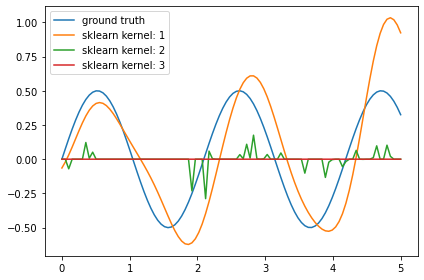

In [10]:
print_GPs(hgdl_GPs, 'hgdl')

In [11]:
del hgdl_GPs[1]

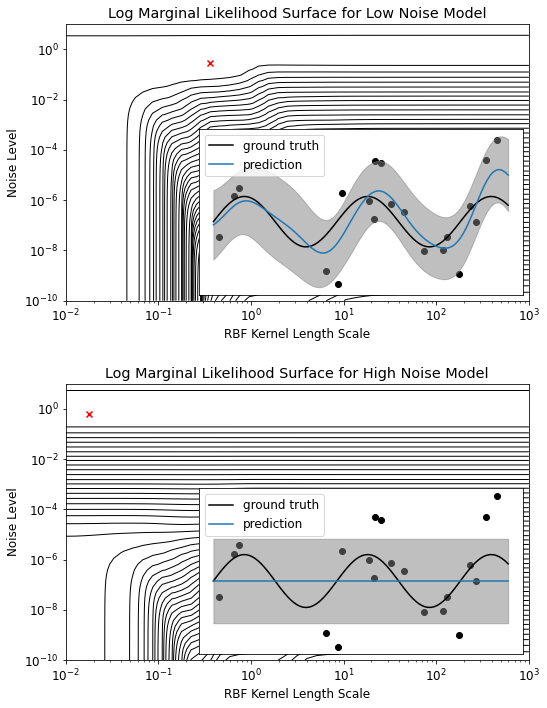

In [20]:
make_plots(hgdl_GPs)

gp - hgdl ( 1 ):  GaussianProcessRegressor(kernel=0.64**2 * RBF(length_scale=0.365) + WhiteKernel(noise_level=0.294),
                         random_state=42) 
kernel: 0.64**2 * RBF(length_scale=0.365) + WhiteKernel(noise_level=0.294)
theta: [-0.89335848 -1.00663904 -1.22409406] [0.40927889 0.36544516 0.29402395]
likelihood: -21.805090890129286
gp - hgdl ( 2 ):  GaussianProcessRegressor(kernel=0.00499**2 * RBF(length_scale=0.0177) + WhiteKernel(noise_level=0.637),
                         random_state=42) 
kernel: 0.00499**2 * RBF(length_scale=0.0177) + WhiteKernel(noise_level=0.637)
theta: [-10.60153106  -4.03237314  -0.45068525] [2.48778911e-05 1.77321989e-02 6.37191364e-01]
likelihood: -23.87230955683211


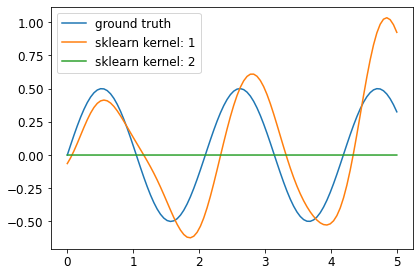

In [13]:
print_GPs(hgdl_GPs, 'hgdl')

In [14]:
np.save('thetas.npy', np.array([x.kernel_.theta for x in hgdl_GPs]))

In [15]:
np.save('log_likelihood.npy', np.array([x.log_marginal_likelihood_value_ for x in hgdl_GPs]))